In [2]:
import cervicalcancerutils as cancer
import numpy as np
from scipy.optimize import check_grad, line_search
import matplotlib.pyplot as plt
from pywt import threshold

In [3]:
filename = 'riskfactorscervicalcancer.csv'
X, y=cancer.load_cervical_cancer(filename)
n,p=X.shape

In [3]:
def tikhonov_old(X, y, w0, w):
    val=0
    grad_w0=0
    grad_w=0
    grad2_w0=0
    grad2_w=0
    grad2_w0_w=0
    
    for i in range(n):
        x=X[i,:].reshape(p,1)
        z = np.exp(-y[i]*(x.T.dot(w)[0]+w0))
        val=val+1/n*np.log(1+z)+1/n*rho/2*np.sum(w**2)
        
        grad_w0=grad_w0+1/n*(-y[i])*z/(1+z)
        grad_w=grad_w+1/n*(-y[i]*x.T)*z/(1+z)+1/n*rho*w
        
        grad2_w0=grad2_w0+1/n*y[i]**2*z/(1+z)**2
        grad2_w=grad2_w+1/n*y[i]**2*x.T.dot(x)*z/(1+z)**2+1/n*rho*np.eye(p)
        grad2_w0_w=grad2_w0_w+1/n*y[i]**2*x.T*z/(1+z)**2
        grad2_w_w0=grad2_w0_w
        
    return val, np.insert(grad_w,0,grad_w0), [[grad2_w0,grad2_w0_w],[grad2_w_w0,grad2_w]]


In [75]:
def tikhonov(X, y, w0w):
    val=0
    grad_w=0
    grad2_w=np.zeros((p+1,p+1))
    
    for i in range(n):
        x=np.insert(X[i,:],0,1).reshape(p+1,1)
        s=np.ones(p+1)
        s[0]=0
        Is=np.diag(s)
        
        z = np.exp(-y[i]*x.T.dot(w0w)[0])
        val=val+1/n*np.log(1+z)+1/n*rho/2*np.sum((s*w0w)**2)
        
        grad_w=grad_w+1/n*(-y[i]*x.T[0])*z/(1+z)+1/n*rho*(s*w0w)
        
        grad2_w=grad2_w+1/n*y[i]**2 * (x.dot(x.T)) * z / (1+z)**2 + 1/n*rho*Is
        
    return val, grad_w, grad2_w

In [74]:
s=np.ones(p+1)
s[0]=0
Is=np.diag(s)
Is

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1

In [173]:
def f1(w0w):
    return tikhonov(X, y, w0w)[0]

def grad(w0w):
    return tikhonov(X, y, w0w)[1]

## Q1.2

In [19]:
rho=1/n
w0w=np.random.rand(p+1)
# w0w=np.ones([p+1,1])
print(check_grad(f1, grad, w0w, epsilon=1e-6))

1.75273799548e-07



## Q1.3 Newton 不收敛

In [174]:
def newton(w0w,epsilon):
    gradient=tikhonov(X, y, w0w)[1]
    G=list([])
    while np.sqrt(np.sum(gradient**2))>=epsilon:
        
        gamma=np.linalg.inv(tikhonov(X, y, w0w)[2])
#         gamma=2
        w0w=w0w-gamma.dot(gradient)
#         w=w-gamma*gradient[1:]
        
        gradient=tikhonov(X, y, w0w)[1]
        
        G.append(np.log10(np.sqrt(np.sum(gradient**2))))
        print(G[-1])
    return w0w, G

In [74]:
def gradientD(w0w,epsilon):
    gradient=tikhonov(X, y, w0w)[1]
    G=list([])
    while np.sqrt(np.sum(gradient**2))>=epsilon:
        
        gamma=2
        w0w=w0w-gamma*gradient
        
        gradient=tikhonov(X, y, w0w)[1]
        
        G.append(np.log10(np.sqrt(np.sum(gradient**2))))
        print(G[-1])
    return w0w, G

-1.19624786561
-1.71192412937
-2.25259148189
-3.0307759966
-4.1675626186
-6.27535024516
-10.4819887535


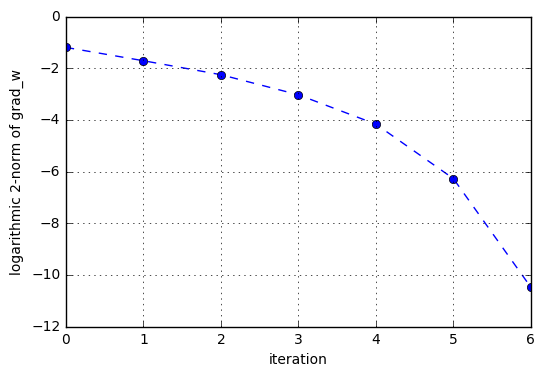

In [175]:
epsilon=1e-10
rho=1/n
w0w=np.zeros(p+1)
# w0w=np.random.rand(p+1)
# w0w_opt,G=gradientD(w0w,1e-5)
w0w_opt,G=newton(w0w,epsilon)

plt.figure()
plt.plot(G,'--o')
plt.xlabel('iteration')
plt.ylabel('logarithmic 2-norm of grad_w')
plt.grid()
plt.show()

## Q1.4 Newton 不收敛

-0.113541180124
nan


c:\program files\python35\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: overflow encountered in exp
c:\program files\python35\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
c:\program files\python35\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
c:\program files\python35\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: overflow encountered in double_scalars


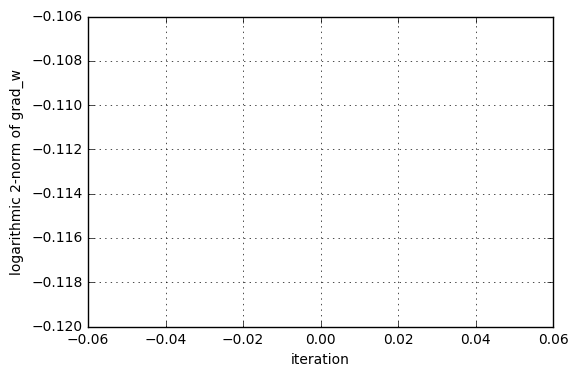

In [85]:
epsilon=1e-10
w0w=0.3*np.ones(p+1)
# w0w=np.random.rand(p+1)
w0w_opt,G=newton(w0w,epsilon)

plt.figure()
plt.plot(G)
plt.xlabel('iteration')
plt.ylabel('logarithmic 2-norm of grad_w')
plt.grid()
plt.show()

In [135]:
np.sum((w0w_opt-0.3*np.ones(p+1))**2)

3.1901759858755439

In [136]:
np.sum((w0w_opt-np.zeros(p+1))**2)

2.3906073446732594

In [137]:
w0w_opt

array([ 0.2013495 , -0.17213872, -0.04798368, -0.14852973,  0.17226181,
       -0.00720006,  0.20673756, -0.03692106,  0.0768277 ,  0.43086559,
        0.12956021,  0.17260728,  0.31592059,  0.17684201,  0.10474188,
        0.10474188, -0.39105042,  0.1639398 ,  0.66262584, -0.33199982,
        0.64063084, -0.39451384, -0.39515206,  0.3884854 ,  0.02848865,
        0.3884854 ,  0.27776305])

## Q1.5

In [163]:
def linesearch(f,grad,w0w):
    a=0.5
    b=2
    beta=1e-3
    l=0
    direction=np.linalg.inv(tikhonov(X, y, w0w)[2]).dot(tikhonov(X, y, w0w)[1])
    w0wplus=w0w-b*a**l*direction
    while f(w0wplus)>f(w0w)+beta*direction.dot(w0wplus-w0w):
        l=l+1
        w0wplus=w0w-b*a**l*direction
    gamma=b*a**l
    return gamma

2.0
-0.954568898423
1.0
-1.56102948655
2.0
-1.6282967948
1.0
-2.97903978604
1.0
-5.53947433547
1.0
-10.1530871989


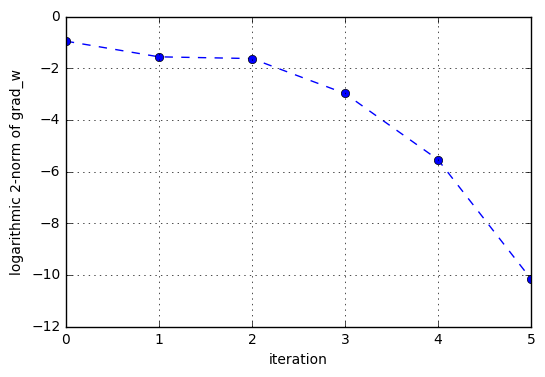

In [164]:
epsilon=1e-10
w0w=np.zeros(p+1)

# w0w=np.random.rand(p+1)
gradient=grad(w0w)
G=list([])
Gamma=list([])
while np.sqrt(np.sum(gradient**2))>=epsilon:
    gamma=linesearch(f1,grad,w0w)
    print(gamma)
    direction=np.linalg.inv(tikhonov(X, y, w0w)[2]).dot(gradient)
    w0w=w0w-gamma*direction
    gradient=grad(w0w)
    G.append(np.log10(np.sqrt(np.sum(gradient**2))))
    Gamma.append(gamma)
    print(G[-1])
w0w_opt=w0w

plt.figure()
plt.plot(G,'--o')
plt.xlabel('iteration')
plt.ylabel('logarithmic 2-norm of grad_w')
plt.grid()
plt.show()

In [160]:
Gamma2=Gamma

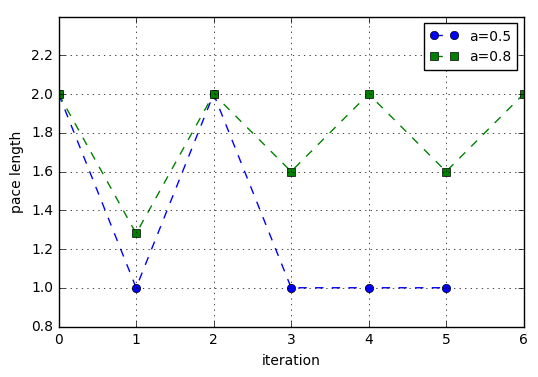

In [162]:

plt.plot(Gamma1,linestyle='--',marker='o',label='a=0.5')
plt.plot(Gamma2,linestyle='--',marker='s',label='a=0.8')
plt.grid()
plt.legend(loc=1,fontsize=10)
plt.xlabel('iteration')
plt.ylabel('pace length')
plt.ylim([0.8,2.4])
plt.xlim([0,6])
plt.show()

## Q2.3

In [166]:
def sparse(X, y, w0w):
    val=0
    grad_w=0
    
    for i in range(n):
        x=np.insert(X[i,:],0,1).reshape(p+1,1)
        s=np.ones(p+1)
        s[0]=0
        z = np.exp(-y[i]*x.T.dot(w0w)[0])
        val=val+1/n*np.log(1+z)
        
        grad_w=grad_w+1/n*(-y[i]*x.T[0])*z/(1+z)
        
    return val, grad_w

In [167]:
def f2(w0w):
    return sparse(X, y, w0w)[0]

def F2(w0w):
    return sparse(X, y, w0w)[0]+rho*np.linalg.norm(w0w[1:],1)

def grad(w0w):
    return sparse(X, y, w0w)[1]

In [168]:
def proximal(w0w,epsilon):
    gradient=grad(w0w)
    C=list([])
    k=0
    while k<2 or np.abs(C[-1]-C[-2])>=epsilon:        
#         gamma=linesearch(f2, grad, w0w)
        gamma=line_search(f2, grad, w0w, -grad(w0w) )[0]
        print(gamma)
        w0w[0]=(w0w-gamma*gradient)[0]
        w0w[1:]=threshold(w0w-gamma*gradient,rho*gamma, mode='soft')[1:]
        
        gradient=grad(w0w)
        
        C.append(F2(w0w))
        k=k+1
        print(C[-1])
    return w0w, C

1.0
0.692841696994
1.0
0.692707377669
1.0
0.692641155027
1.0
0.692606381277
1.0
0.692587637032
1.0
0.692577319483
1.0
0.692571579618
1.0
0.692568368211
1.0
0.692566565896
1.0
0.692565552591
1.0
0.692564982201


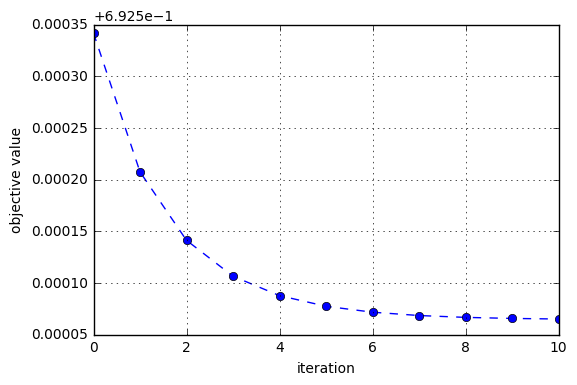

In [171]:
epsilon=1e-6
w0w=np.zeros(p+1)
# w0w=np.random.rand(p+1)
rho=0.1
w0w_opt,C=proximal(w0w,epsilon)

plt.figure()
plt.plot(C,'--o')
plt.xlabel('iteration')
plt.ylabel('objective value')
plt.grid()
plt.show()

In [40]:
r2

array([-0.05473986,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00594368,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00661137,  0.        ,  0.        ,  0.01808848,  0.        ,
        0.01808848,  0.        ])

## Q3.2

In [176]:
r1=w0w_opt

In [172]:
r2=w0w_opt

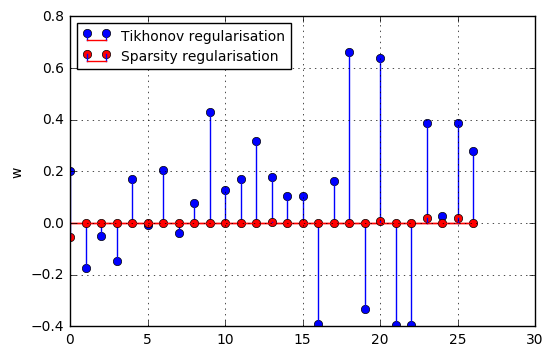

In [177]:
plt.stem(r1,markerfmt='bo',label='Tikhonov regularisation')
plt.stem(r2,markerfmt='ro',label='Sparsity regularisation')
plt.grid()
plt.legend(loc=2,fontsize=10)
plt.ylabel('w')
plt.show()


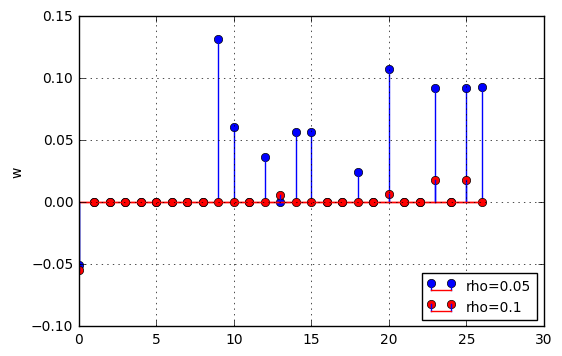

In [43]:
plt.stem(r1,markerfmt='bo',label='rho=0.05')
plt.stem(r2,markerfmt='ro',label='rho=0.1')
plt.grid()
plt.legend(loc=4,fontsize=10)
plt.ylabel('w')
plt.show()


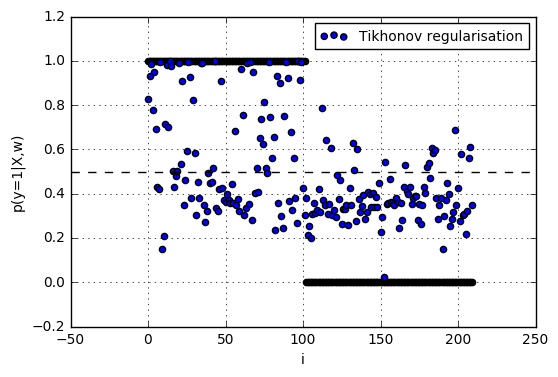

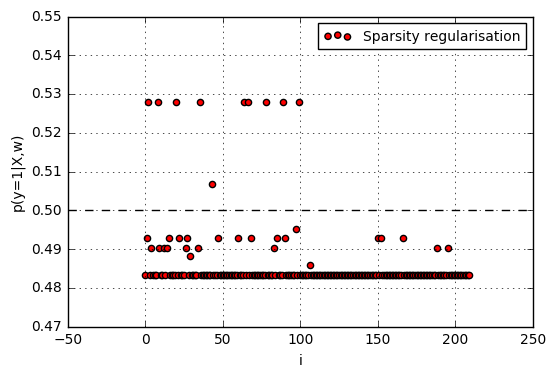

In [35]:
y_est1=np.zeros(n)
y_est2=np.zeros(n)

for i in range(n):
    x=np.insert(X[i,:],0,1).reshape(p+1,1)
    y_est1[i]=1/(1+np.exp(-x.T.dot(r1)))
    y_est2[i]=1/(1+np.exp(-x.T.dot(r2)))
    y_est0=y*0.5+0.5
plt.figure()
plt.scatter(range(n),y_est0,c='black')
plt.scatter(range(n),y_est1,label='Tikhonov regularisation')
plt.axhline(y=0.5,linestyle='--',color='black')
plt.grid()
plt.xlabel('i')
plt.ylabel('p(y=1|X,w)')
plt.legend(loc=1,fontsize=10)
plt.show()

# plt.figure()
# # plt.scatter(range(n),y_est0,c='black')
# plt.scatter(range(n),y_est2,c='r',label='Sparsity regularisation')
# plt.axhline(y=0.5,linestyle='--',color='black')
# plt.grid()
# plt.xlabel('i')
# plt.ylabel('p(y=1|X,w)')
# plt.legend(loc=1,fontsize=10)
# plt.show()